<a href="https://colab.research.google.com/github/swanny0000/ZTM-TensorFlow/blob/master/06_Transfer_Learning_pt_3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/learn/lecture/25202462#content
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

SO! We've started with a small dataset, and a small model. After some experimenting and finding out what works, we've scaled up our model, then our data, etc etc etc all they way to 7500 training examples!

# Scaling up
Our goal is to beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with 10% of our training data! They had an average accuracy of 50.76% across 101 classes - let's beat it.

In [2]:
# let's get our helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2023-12-09 04:52:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-09 04:52:02 (78.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# and let's get our data! It's already been preprocessed for us
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

walk_through_dir("101_food_classes_10_percent")

--2023-12-09 04:52:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  83.8MB/s    in 14s     

2023-12-09 04:52:27 (110 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_fries'.
There are 0 directories and 250 

yowza!

We can import that data into a TensorFlow Dataset to make it easier to manage with code, too.

In [4]:
# set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
# let's get to training... feature extraction into fine tuning
# * ModelCheckpoint callback
# * Data augmentation layer
# * EfficientNetB0 Model
# * Feature extraction for 5 passes, using 15% of the validation dataset

checkpoint_path = "101_classes_10_percent_callback"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True)

augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(.2),
    tf.keras.layers.RandomHeight(.2),
    tf.keras.layers.RandomWidth(.2),
    tf.keras.layers.RandomZoom(.2),
    tf.keras.layers.RandomFlip("horizontal"),
    #tf.keras.layers.Rescaling(1/255.) # required for ResNetV50 or other models that expect 0-1 values
], name="augmentation_layer")

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = augmentation_layer(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequen  (None, None, None, 3)     0         
 tial)                                                           
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling (GlobalAveragePool  (None, 1280)              0         
 ing2D)                                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381 

In [6]:
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

history_feature_extraction = model.fit(train_data_all_10_percent,
                                       epochs=5,
                                       steps_per_epoch=len(train_data_all_10_percent),
                                       validation_data=test_data,
                                       validation_steps=int(.15 * len(test_data)),
                                       callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 152s 563ms/step - loss: 3.5198 - accuracy: 0.2318 - val_loss: 2.5755 - val_accuracy: 0.4526
Epoch 2/5
237/237 [==============================] - 86s 363ms/step - loss: 2.4160 - accuracy: 0.4466 - val_loss: 2.1089 - val_accuracy: 0.5061
Epoch 3/5
237/237 [==============================] - 83s 344ms/step - loss: 2.0450 - accuracy: 0.5162 - val_loss: 1.9221 - val_accuracy: 0.5381
Epoch 4/5
237/237 [==============================] - 71s 300ms/step - loss: 1.8340 - accuracy: 0.5583 - val_loss: 1.8450 - val_accuracy: 0.5397
Epoch 5/5
237/237 [==============================] - 54s 224ms/step - loss: 1.6988 - accuracy: 0.5827 - val_loss: 1.7373 - val_accuracy: 0.5559


In [7]:
# let's see how it performs on all test examples...
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 68s 86ms/step - loss: 1.6337 - accuracy: 0.5693


wow - with 10% of the original data, and in less than 10 minutes, we beat the paper! That's the power of transfer learning!

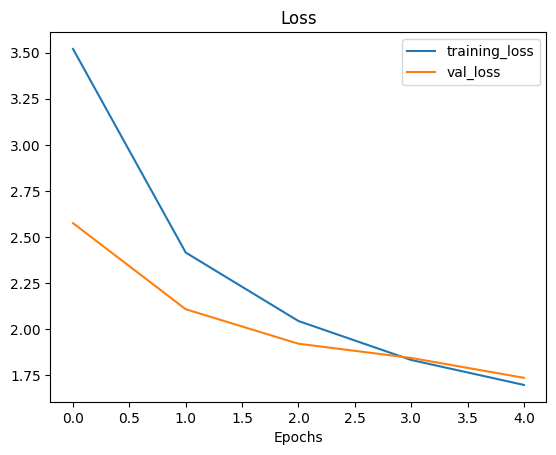

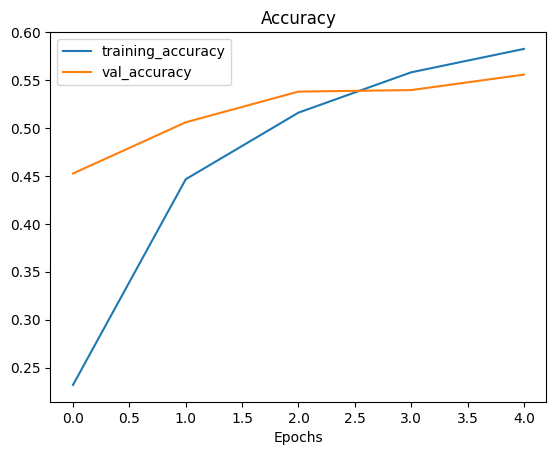

In [8]:
plot_loss_curves(history_feature_extraction)

hm, the splitting of these curves means that our model is overfitting... great! that's the first step :)

Let's get to fine tuning!

In [9]:
# unfreeze some layers and lower the learning rate!
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              metrics=["accuracy"])

model.summary()
for layer_number, layer in enumerate(model.layers[2].layers):
  if layer.trainable == True:
    print(layer_number, layer.name)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequen  (None, None, None, 3)     0         
 tial)                                                           
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling (GlobalAveragePool  (None, 1280)              0         
 ing2D)                                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [10]:
history_fine_tuning = model.fit(train_data_all_10_percent,
                                epochs=10,
                                initial_epoch=history_feature_extraction.epoch[-1],
                                steps_per_epoch=len(train_data_all_10_percent),
                                validation_data=test_data,
                                validation_steps=int(.15*len(test_data)),
                                callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 73s 257ms/step - loss: 1.4817 - accuracy: 0.6285 - val_loss: 1.7325 - val_accuracy: 0.5440
Epoch 6/10
237/237 [==============================] - 57s 240ms/step - loss: 1.3956 - accuracy: 0.6380 - val_loss: 1.7374 - val_accuracy: 0.5434
Epoch 7/10
237/237 [==============================] - 50s 208ms/step - loss: 1.3346 - accuracy: 0.6528 - val_loss: 1.7258 - val_accuracy: 0.5461
Epoch 8/10
237/237 [==============================] - 48s 200ms/step - loss: 1.2949 - accuracy: 0.6653 - val_loss: 1.7362 - val_accuracy: 0.5426
Epoch 9/10
237/237 [==============================] - 59s 246ms/step - loss: 1.2561 - accuracy: 0.6671 - val_loss: 1.7307 - val_accuracy: 0.5450
Epoch 10/10
237/237 [==============================] - 48s 194ms/step - loss: 1.2055 - accuracy: 0.6807 - val_loss: 1.7030 - val_accuracy: 0.5524


In [11]:
# how much did validation actually improve?
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 74s 94ms/step - loss: 1.4818 - accuracy: 0.6008


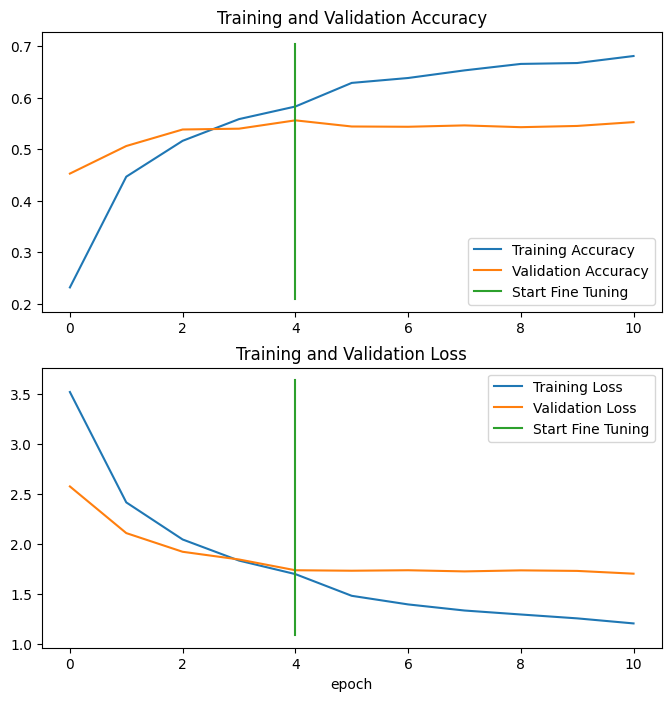

In [12]:
compare_historys(original_history=history_feature_extraction,
                 new_history=history_fine_tuning,
                 initial_epochs=5)

so for us, fine tuning really helped out with training accuracy and loss, but not for our validation datasets... we're still overfitting!

Let's look at how our model works on predicting. First, we'll need to save our model off and load it in for whatever web/phone app we'd want to use.

In [13]:
model.save("drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_model")

In [14]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_model")

In [15]:
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.4818 - accuracy: 0.6008


In [16]:
loaded_model_results, fine_tuning_results

([1.4818040132522583, 0.6007920503616333],
 [1.4818040132522583, 0.6007920503616333])

## Predicting with our model

How can we fine what our model's WORST evaluations are? Let's use a presaved model to do our bidding.

In [17]:
import tensorflow as tf
# let's get our helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
# let's download another model to use
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")
pretrained_model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

--2023-12-09 05:12:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-09 05:12:21 (112 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

--2023-12-09 05:12:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting

we can ignore these warnings... let's make sure that's the case

In [18]:
pretrained_model_results = pretrained_model.evaluate(test_data)

790/790 [==============================] - 66s 81ms/step - loss: 1.8027 - accuracy: 0.6078


great... but how can we tell class-by-class how our model performs?

In [19]:
# let's start with visualizing a few predictions
preds_probs = pretrained_model.predict(test_data, verbose=1)

790/790 [==============================] - 76s 94ms/step


In [20]:
# how many predictions do we have? one for every test image!
len(preds_probs)

25250

In [21]:
# how many values per each test case? 101 - one for each class, since we're using a softmax function!
preds_probs.shape

(25250, 101)

In [22]:
preds_probs[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [23]:
max(preds_probs[0]), sum(preds_probs[0]), tf.argmax(preds_probs[0])

(0.8474181, 0.9999999913078492, <tf.Tensor: shape=(), dtype=int64, numpy=52>)

In [24]:
# what class is that?
test_data.class_names[52]

'gyoza'

In [25]:
# let's get teh pred classes from each array...
pred_classes = preds_probs.argmax(axis=1)

In [26]:
# how can we tell what predictions are correct and incorrect? we need to unbatch our data
test_data


In [27]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #don't want onehot encoded list...
y_labels[:10] #remember shuffle=False when we loaded in our data!

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [28]:
# now we've got y_labels and pred_classes organized together... right? What's the accuracy score?
import sklearn
sklearn_accuracy = sklearn.metrics.accuracy_score(y_true=y_labels,
                                                  y_pred=pred_classes)
sklearn_accuracy, loaded_model_results

(0.6077623762376237, [1.4818040132522583, 0.6007920503616333])

### Confusion Matrix

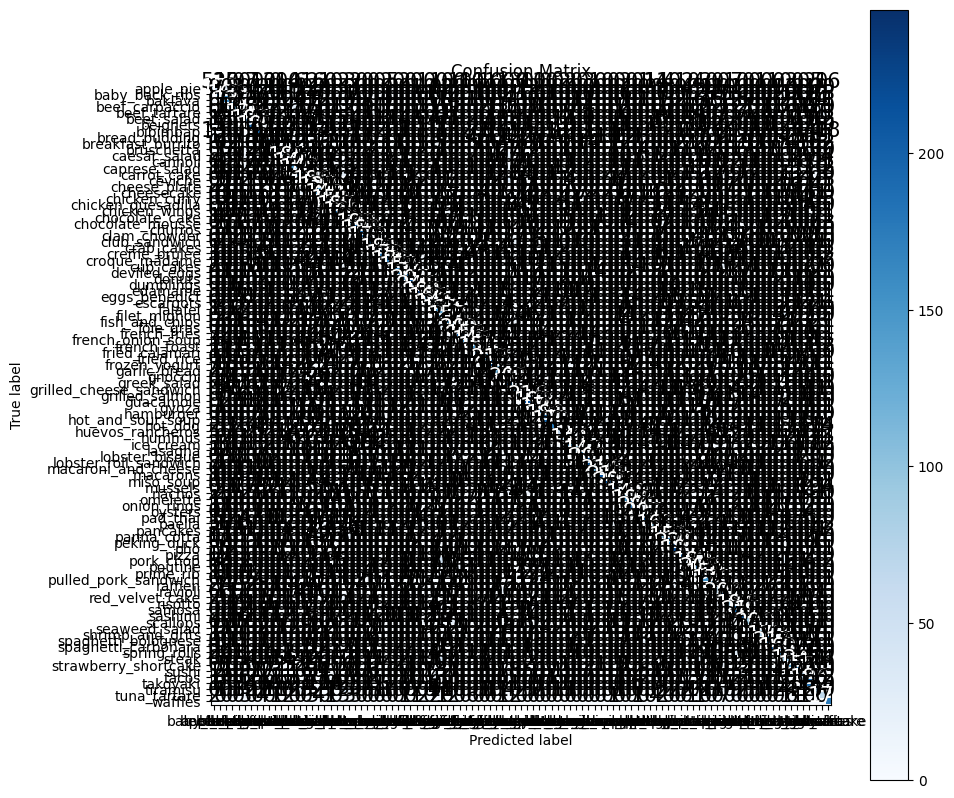

In [29]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20)

In [ ]:
#let's make the confusion matric have the prediction labels (x-axis) print vertically
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [33]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

AttributeError: ignored

what other metrics can we look at?
* accuracy
* precision
* recall
* f1 score

Let's make a classification report!

In [38]:
print(sklearn.metrics.classification_report(y_true=y_labels,
                                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

This report gives data class-by-class, so our model is not very good at class 0, but is very good at predicting class 33!

In [40]:
# let's plot out f1 scored by class
classification_report_dict = sklearn.metrics.classification_report(y_true=y_labels,
                                                                   y_pred=pred_classes,
                                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [43]:
class_names = test_data.class_names
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [45]:
# get ready for visualization using a dataframe
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

f1_scores[:10]

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
68,onion_rings,0.832618
65,mussels,0.820000
88,seaweed_salad,0.813008
64,miso_soup,0.812977
45,frozen_yogurt,0.811429


from matplotlib import pyplot as plt
_df_0['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

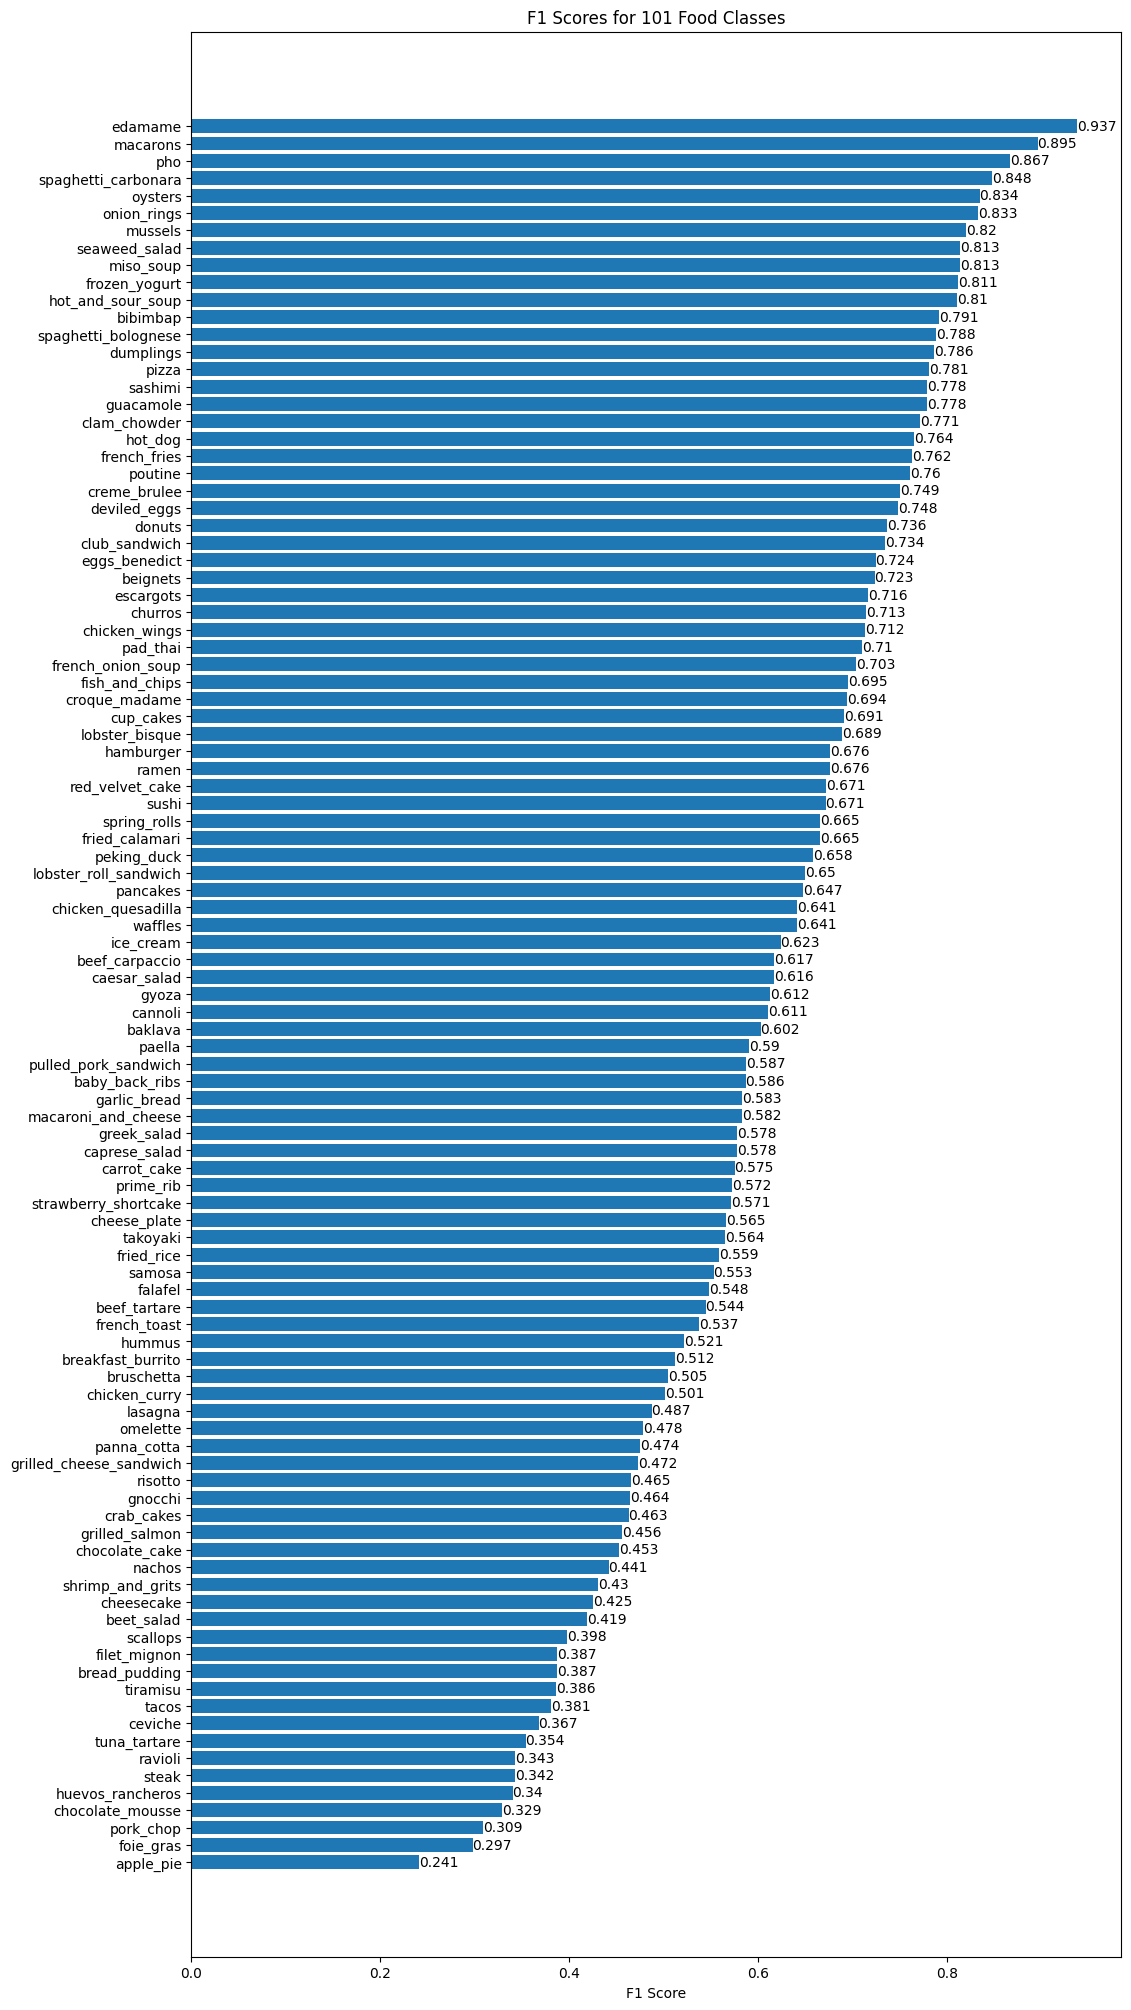

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)),
                 f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.bar_label(scores, [round(score, 3) for score in f1_scores["f1-score"]])
ax.set_xlabel("F1 Score")
ax.set_title("F1 Scores for 101 Food Classes")
ax.invert_yaxis()

how mught we fix these issues? We might limit those classes from being enabled for our application while we train some more

In the meantime, let's visualize some of the lowest-performing classes... we'll need a function to load and preprocess images:
* read in a target image filepath using `tf.io.read_file()`
* turn the image into a Tensor using `tf.io.decode_image()`
* resize the image tensor to the input size of our model using `tf.image.resize()`
* scale the image to get the pixel values between 0 and 1 (if necessary)


In [51]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from a filename, turns it into a tensor, and reshapes into specified shape.
  """
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.resize(img, size=[img_shape, img_shape])
  if scale: return img/255.
  else: return img